In [37]:
import numpy as np
import awkward as ak
import pickle

path_to_pickles="/home/rusack/shared/pickles/HGCAL_TestBeam/pickle_0to1M/"
zfile=path_to_pickles+"Hit_Z.pickle"
efile=path_to_pickles+"recHitEn.pickle"
truefile=path_to_pickles+"ratio_target.pickle"

with open(zfile, "rb") as f_:
    z = pickle.load(f_)
with open(efile, "rb") as f_:
    e=pickle.load(f_)
with open(truefile, "rb") as f_:
    te=pickle.load(f_)
layer_pos = np.unique(np.array(ak.flatten(z)))

In [2]:
arr = [ak.sum(e[z==layer_pos[i]], axis=1) for i in range(1,51)]
arr = np.array(arr)
arr = arr.T

In [38]:
with open("layer_energy_sum.pickle","wb") as f_:
    pickle.dump(arr, f_)

<Array [1.6e-43, 5.44e-43, ... 1.39e-43] type='836658 * float32'>

In [1]:
#!/home/rusack/joshib/.conda/envs/fair_gpu/bin/python
import os,sys
from tqdm import tqdm
import pickle
import torch

/home/rusack/shared/.conda/env/torch1.9/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from models.DNN import NN
from dataset_utils import H5DatasetDNN, split_dataset
from torch.utils.data.dataloader import default_collate
from utils.torch_utils import MARELoss, train

EPOCHS = 100
TRAIN_BATCH_SIZE = 10000
LAYERS = [50, 40, 30, 1] # shape of DNN
LRATE = 1e-2 # learning rate
TRAINING_FOLDER="../training/test_epochs_100_lr_0p01_bs_1e5"

if not os.path.exists(TRAINING_FOLDER):
        os.system('mkdir -p {}'.format(TRAINING_FOLDER))

file_path = '/home/rusack/shared/hdf5/hgcal_pion/hgcal_pions_combinedHgc_Ahc_1.h5'
dataset = H5DatasetDNN(file_path)
train_test_datasets = split_dataset(dataset)

In [ ]:
import os,sys
from tqdm import tqdm
import pickle
import numpy as np
import h5py
file_path = '/home/rusack/shared/hdf5/hgcal_pion/hgcal_pion_data_0to1M_combinedHgc_Ahc.h5'
file = h5py.File(file_path)
z = np.array(file['rechit_z'])
layer_pos = np.unique(z)
print(len(layer_pos))
print(layer_pos)

In [2]:
import os, sys
sys.path.append(os.getcwd().replace('/notebooks','/src'))

In [7]:
import h5py
import torch
import pickle
import numpy as np
from utils.fit_utils import GausPDF, Pol1PDF, fit_gaussian_res
from matplotlib import pyplot as plt
from scipy import interpolate
import io

In [15]:
from scipy.optimize import curve_fit

In [8]:
#with open('../src/nn_output.pkl','rb') as f_:
#    predictions = torch.load(f_, map_location=torch.device('cpu'))
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

#contents = pickle.load(f) becomes...
with open('../src/nn_output.pkl','rb') as f_:
    predictions = CPU_Unpickler(f_).load()

In [9]:
file_path = '/home/rusack/shared/hdf5/hgcal_pion/hgcal_pions_combinedHgc_Ahc_2.h5'
file = h5py.File(file_path)
targets = np.array(file['true_energy'])

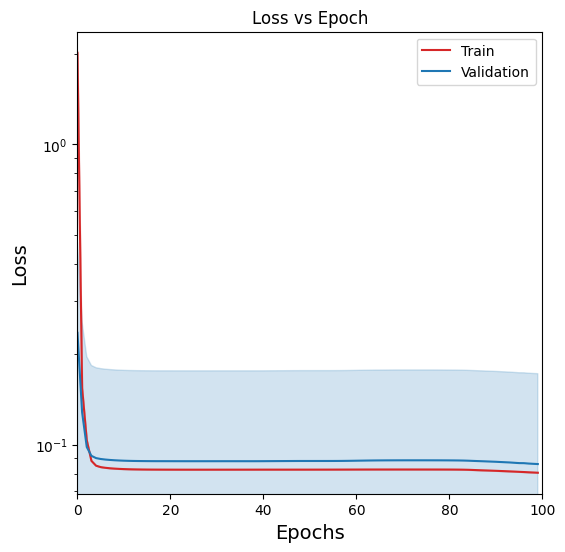

In [10]:
summary_file = '../training/test_epochs_100_lr_0p01_bs_1e5/summary.pkl'
with open(summary_file, 'rb') as f0:
    trs = pickle.load(f0)
epochs = trs['epochs']
training_loss = trs['train_loss']
valid_loss = trs['valid_loss']

T = np.average(np.array(training_loss).reshape(100,1), axis=1)
dT = np.std(np.array(training_loss).reshape(100,1), axis=1)
V = np.average(np.array(valid_loss).reshape(100,1), axis=1)
dV = np.average(np.array(valid_loss).reshape(100,1), axis=1)
E = np.arange(0,100,1)

plt.figure(figsize=(6,6))
plt.plot(E, T, label='Train', color='tab:red')
plt.plot(E, V, label='Validation', color='tab:blue')
plt.fill_between(E, T-dT, T+dT, color='tab:red', alpha=0.2)
plt.fill_between(E, V-dV, V+dV, color='tab:blue', alpha=0.2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss vs Epoch')
plt.legend(loc='upper right')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(0,100)
plt.show()

<Figure size 640x480 with 0 Axes>

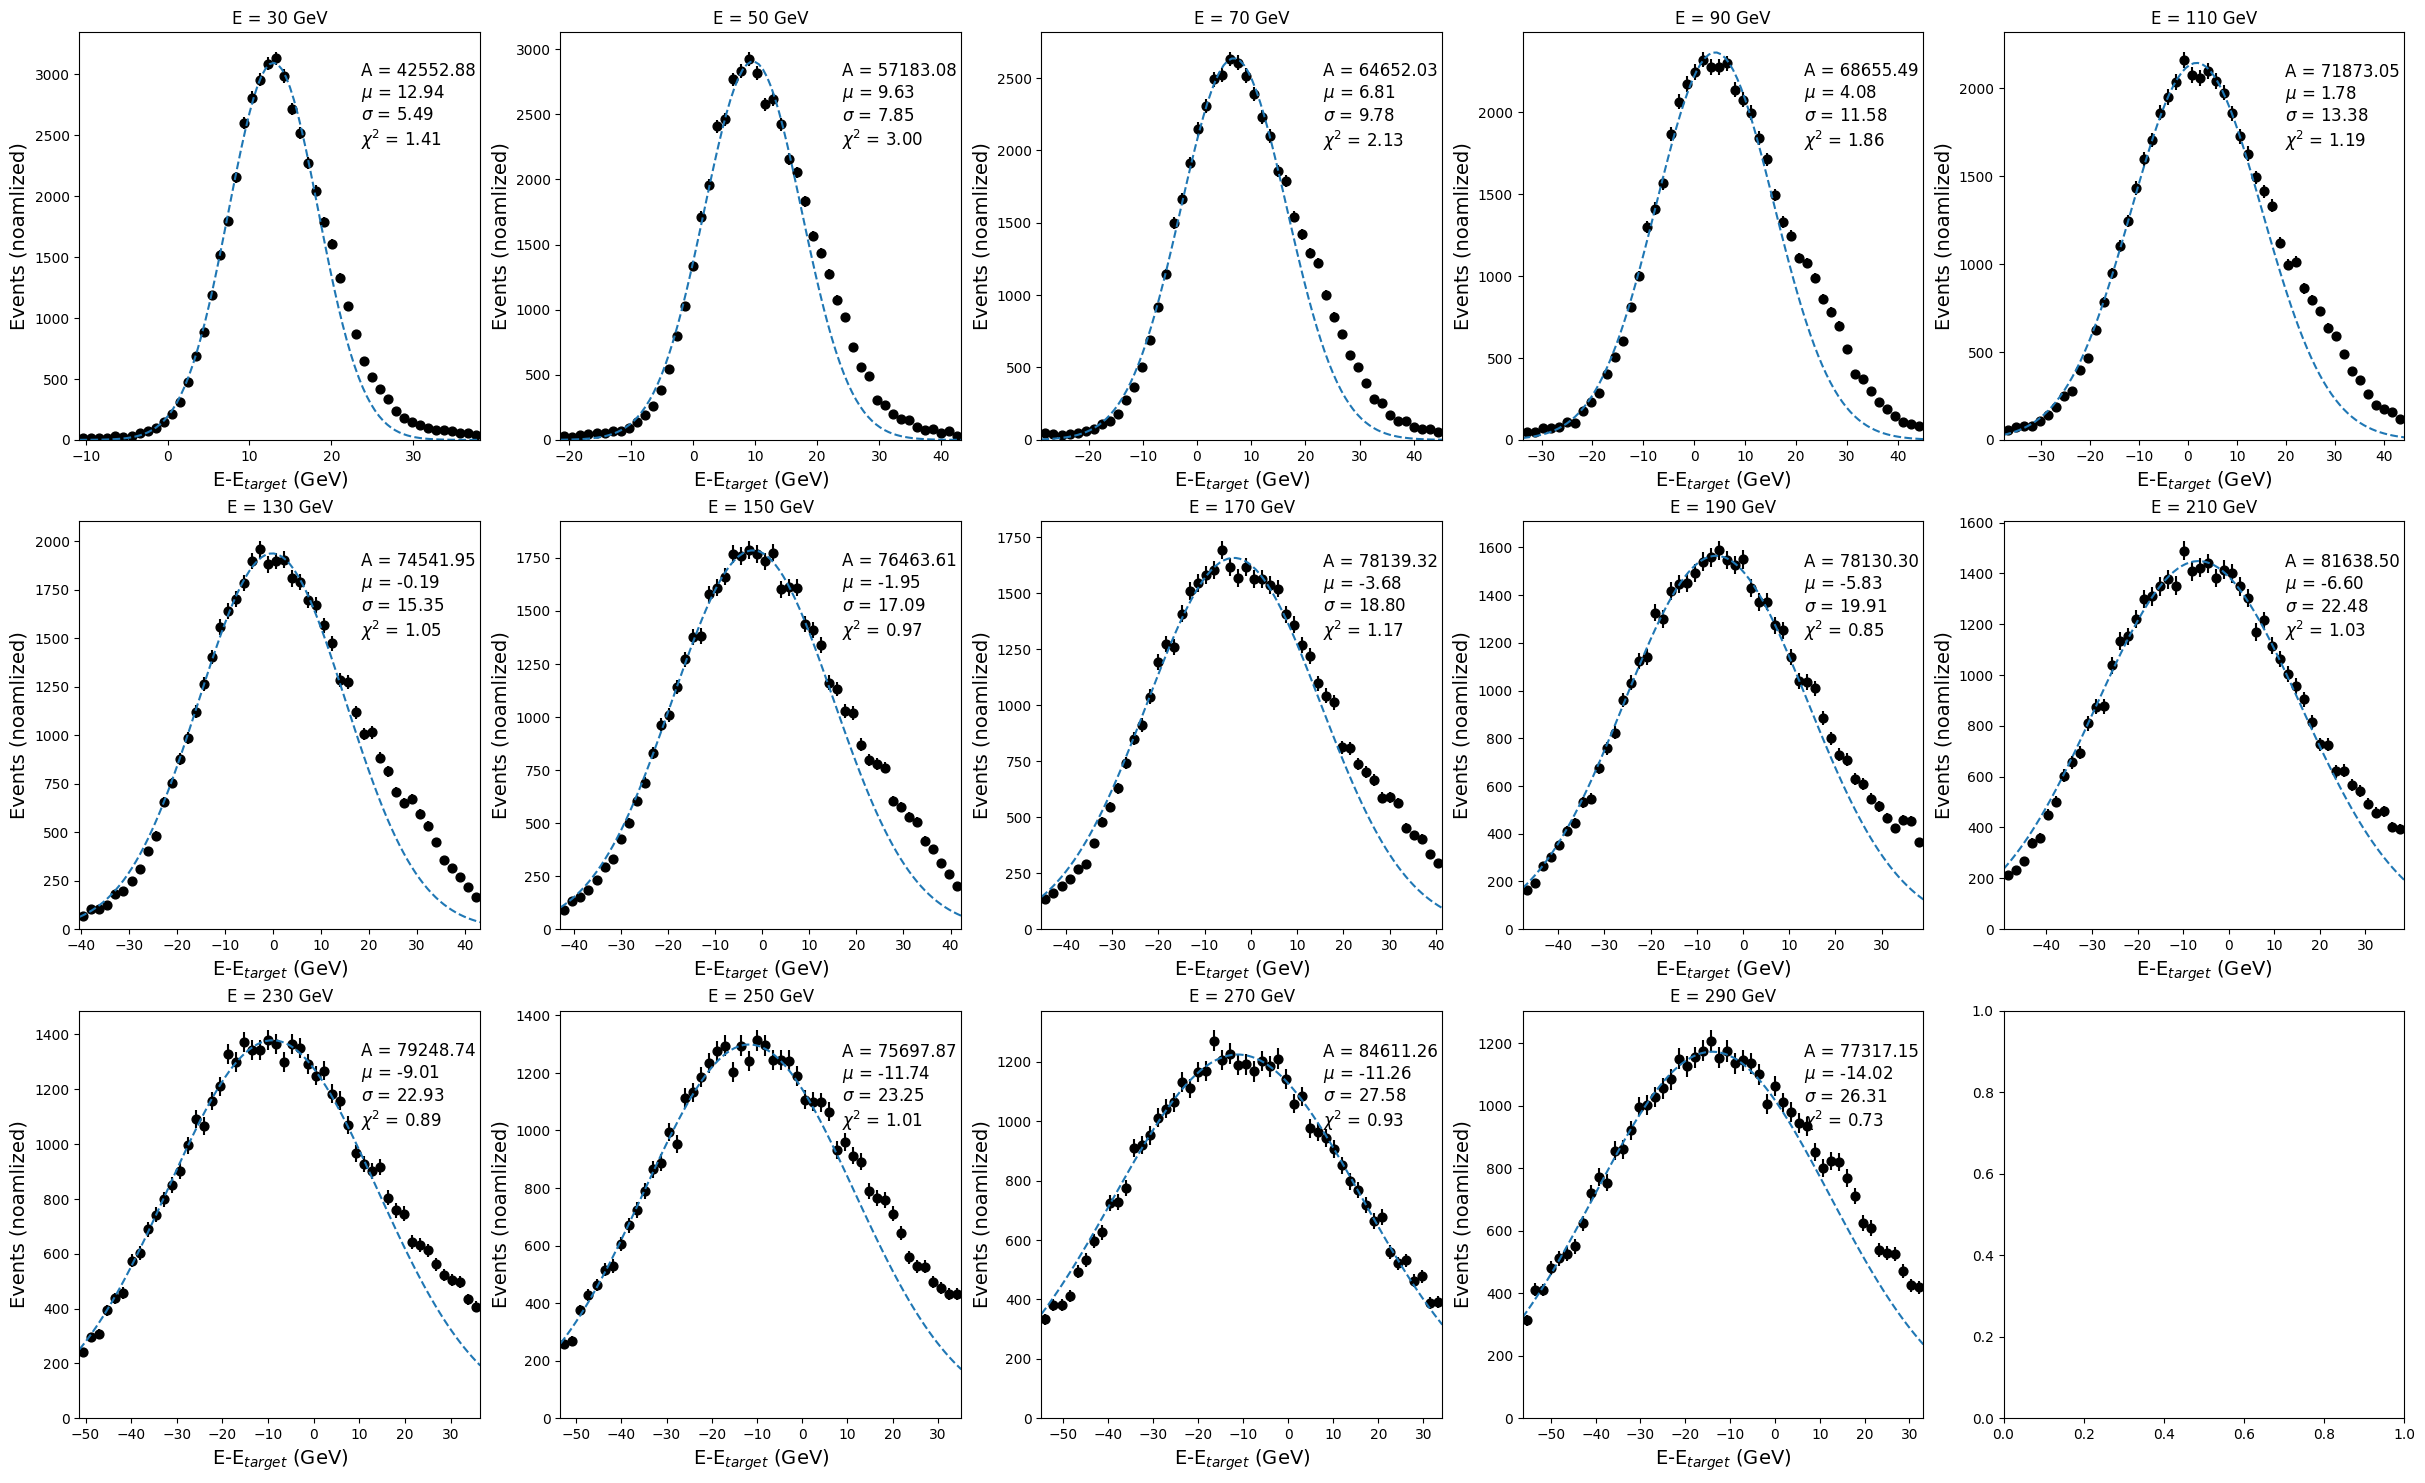

In [11]:
fit_parameters_ml_train = {}
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(predictions)[mask]
    fit_parameters_ml_train[e] = fit_gaussian_res_iter(P-T, axarray[irow, jcol], 'mc', e)
plt.show()

In [44]:
def fit_gaussian_res_iter(earray, ax, dtype, energy):
    
    nsigma = 5.0
    
    mean_ = np.mean(earray)
    std_ = np.std(earray)
    mean_ = np.mean(earray[(earray>mean_-20)*(earray<mean_+20)])
    std_ = np.std(earray[(earray>mean_-20)*(earray<mean_+20)])
    data_range = (mean_-100, mean_+100)
    f = 1.0
    
    # plot data
    data_hist2_array = ax.hist(earray, 
            histtype='step', color='w', linewidth=0,
             range=data_range, bins=50)
    xarray = ((data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2)
    yarray = data_hist2_array[0]
    
    
    for i in range(5):
        mask = (xarray>mean_-2.0*std_)*(xarray<mean_+1.0*std_)
        results = curve_fit(GausPDF, xarray[mask], yarray[mask],
                        p0=(max(yarray), mean_, std_),
                        bounds=((0,-1e2,0),(1e3*max(yarray),1e3,1e3)))
        mean_ = results[0][1]
        std_ = results[0][2]
    #data_range = (mean_-nsigma*std_, mean_+nsigma*std_)
    M = np.linspace(data_range[0], data_range[1], 100)
    
    data_hist2_array = ax.hist(earray,
             histtype='step', color='w', linewidth=0,
             range=data_range, bins=50)
    xarray = ((data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2)
    yarray = data_hist2_array[0]
    
    dE = yarray-np.array([ f*GausPDF(m, *results[0]) for m in xarray])
    E = (dE/(np.sqrt(yarray+0.001)))
    chi2 = np.sqrt(sum(E[mask]**2)/(len(E[mask])-1))

    ax.scatter(xarray, yarray, marker='o', c='black', s=40)
    ax.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))
    ax.plot(M, [ f*GausPDF(m, *results[0]) for m in M], linestyle='dashed')

    # plot data
    ax.set_xlim(data_range)
    ax.set_ylabel('Events (noamlized)', size=14)
    ax.set_xlabel('E-E$_{target}$ (GeV)', size=14)
    stat_text = '''
    A = {:0.2f}
    $\mu$ = {:0.2f}
    $\sigma$ = {:0.2f}
    $\chi^2$ = {:0.2f}
    '''.format(results[0][0], results[0][1], results[0][2], chi2)
    stat_text_box = ax.text(x=mean_+1.2*std_, y=0.7*max(yarray),
        s=stat_text,
        fontsize=12,
        fontfamily='sans-serif',
        horizontalalignment='left', 
        verticalalignment='bottom')
    ax.set_title('E = {} GeV'.format(energy))
    return results[0], dE

<Figure size 640x480 with 0 Axes>

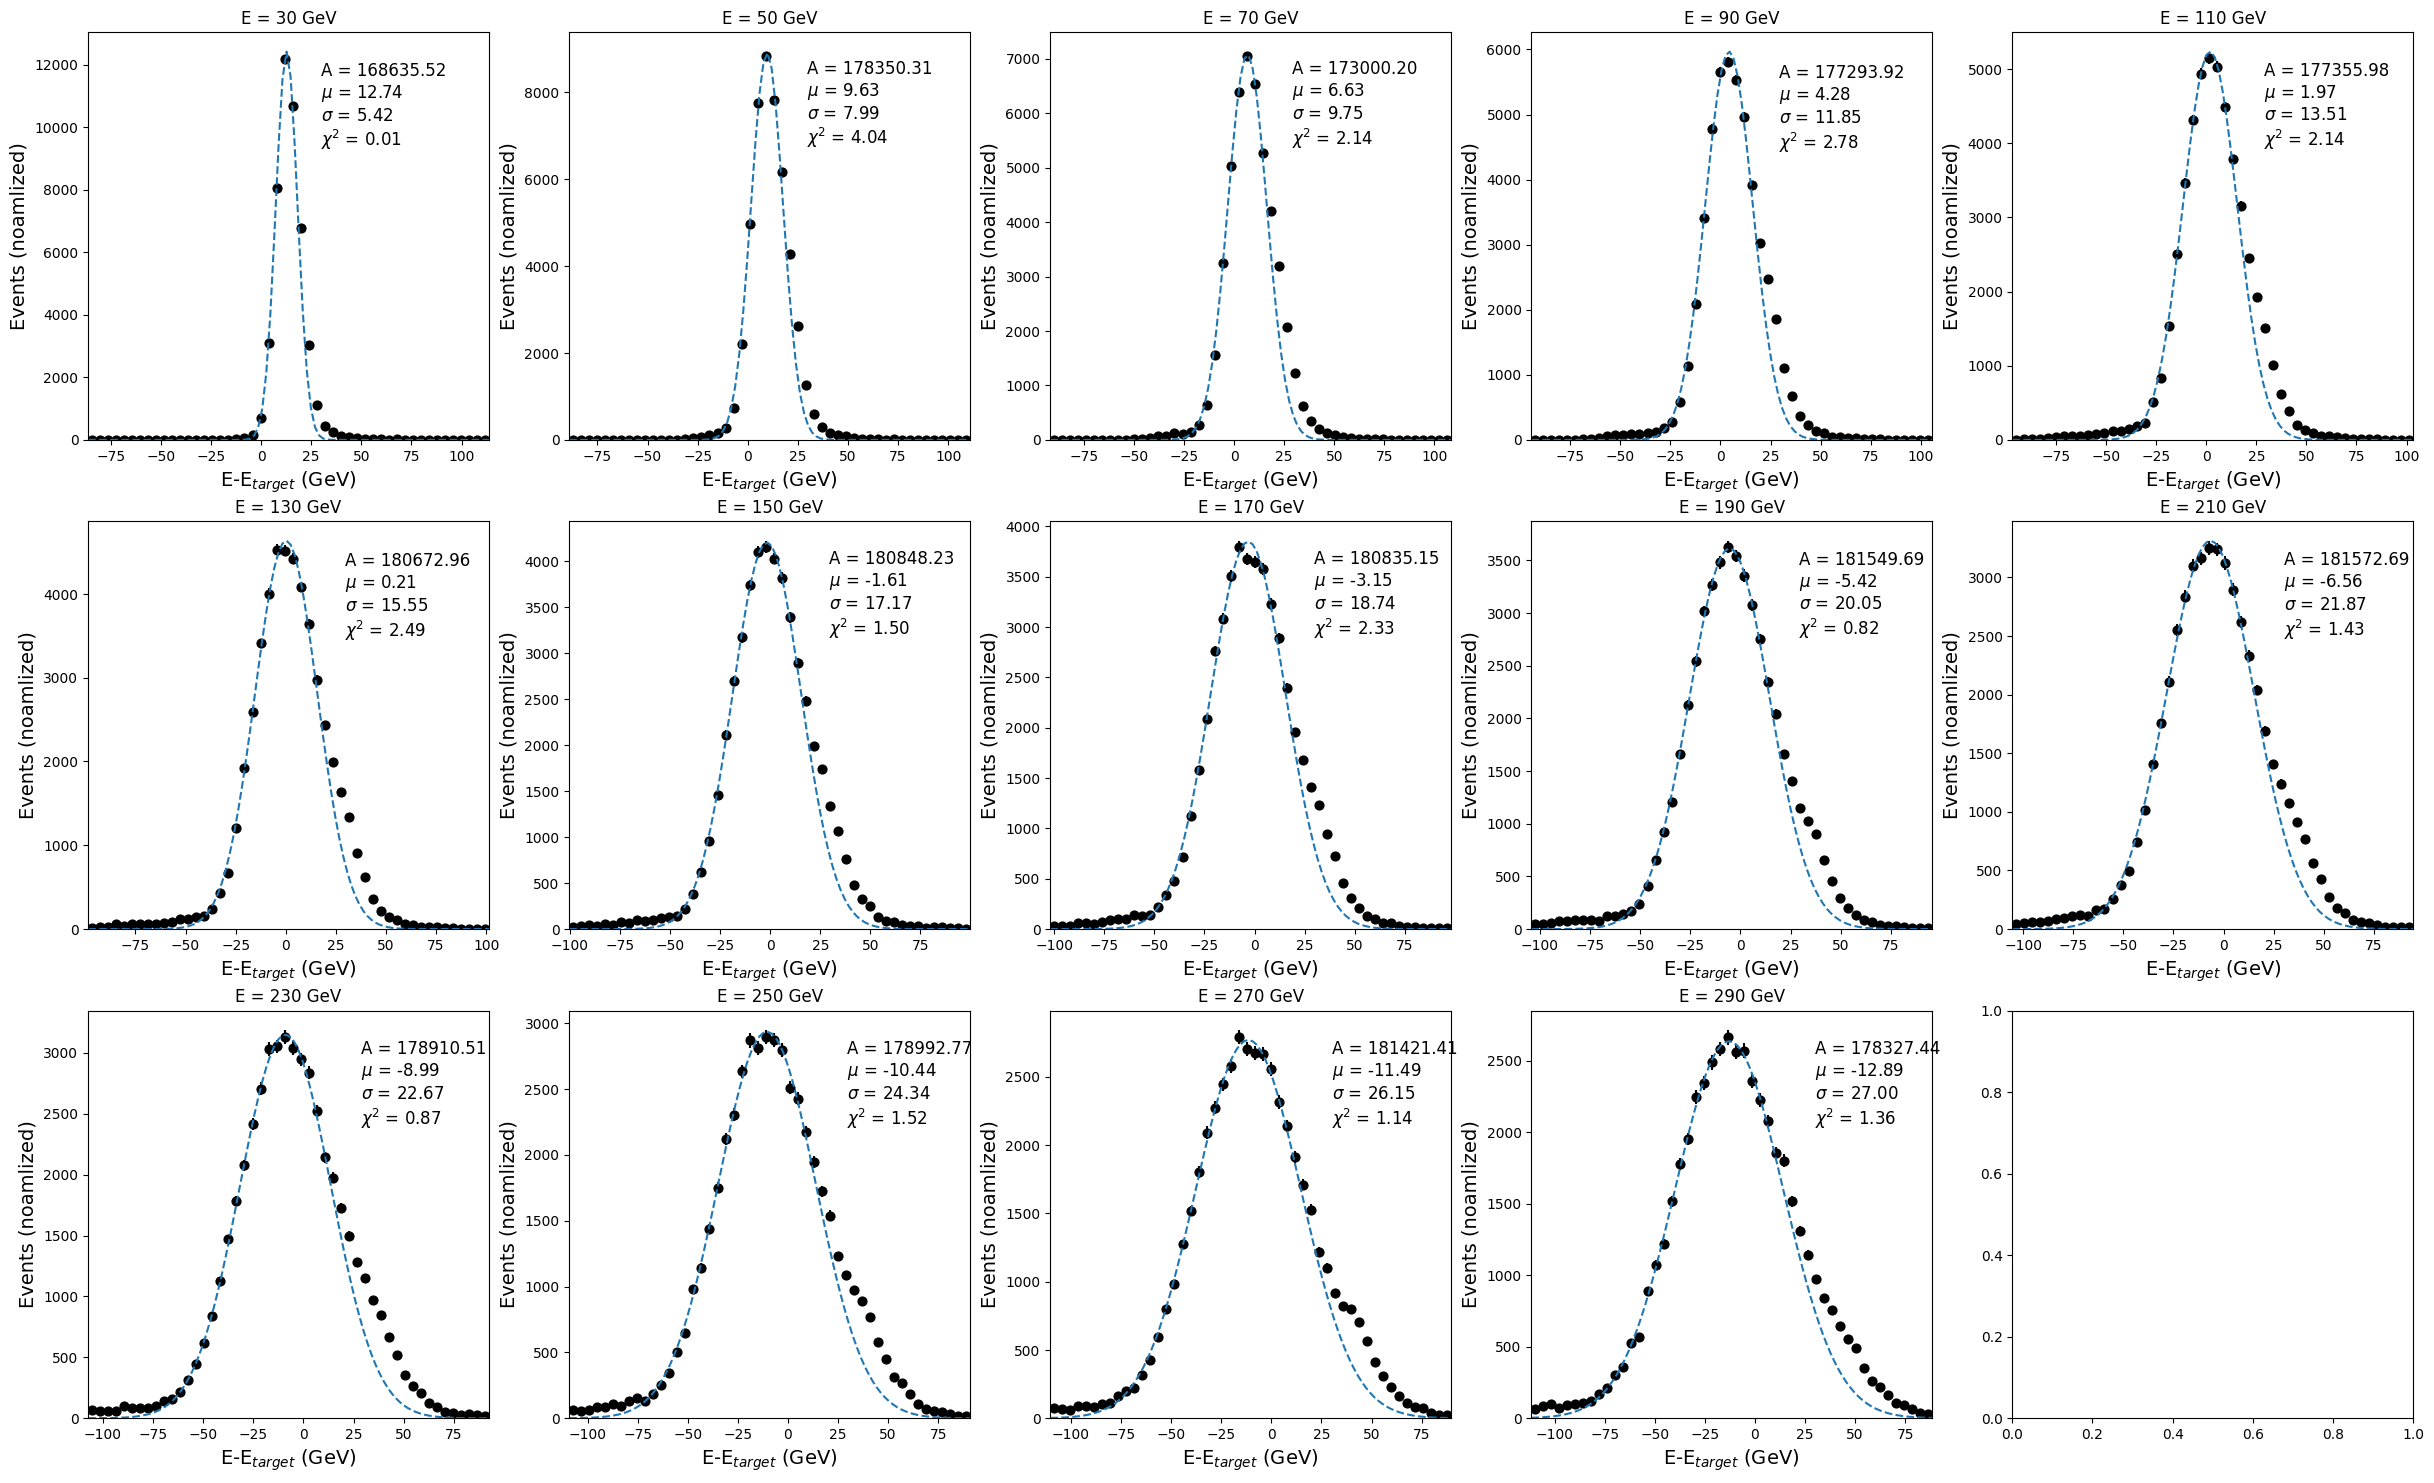

In [45]:
fit_parameters_ml_train = {}
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(predictions)[mask]
    fit_parameters_ml_train[e] = fit_gaussian_res_iter(P-T, axarray[irow, jcol], 'mc', e)
plt.show()

In [48]:
fit_parameters_ml_train.pop(30)

(array([1.68635525e+05, 1.27400610e+01, 5.41621199e+00]),
 array([-2.54820666e-66, -1.08042776e-60, -2.65512655e-55, -3.78183973e-50,
        -3.12211876e-45, -1.49390893e-40, -4.14311730e-36, -6.65976249e-32,
        -6.20466955e-28, -3.35047958e-24, -1.04863343e-20, -1.90225540e-17,
        -2.00005693e-14, -1.21883325e-11, -4.30501465e-09, -8.81319495e-07,
        -1.04573230e-04,  5.99280823e+00,  2.97133315e+01,  6.33770360e+01,
         7.73143905e+01,  1.96927833e+01,  7.22371821e-01, -8.31181925e-01,
         5.50024113e-01, -2.09323367e-01,  1.35856859e+03,  1.44392309e+03,
         8.35803955e+02,  4.08094677e+02,  2.51458573e+02,  1.16948816e+02,
         8.49990149e+01,  4.69999890e+01,  3.09999999e+01,  2.50000000e+01,
         2.40000000e+01,  1.00000000e+01,  1.30000000e+01,  1.00000000e+01,
         5.00000000e+00,  5.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         2.00000000e+00, -1.36333806e-47,  1.00000000e+00, -6.82355191e-58,
        -2.13013229e-63, -3.85

In [49]:
fit_parameters_sum = fit_parameters_ml_train

<Figure size 640x480 with 0 Axes>

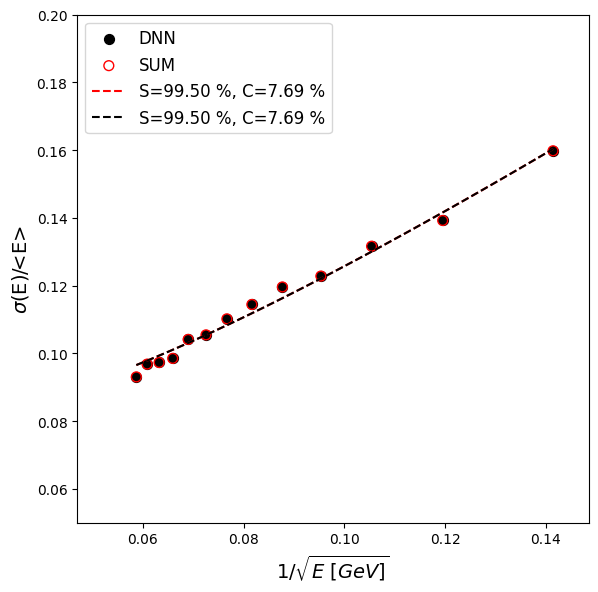

In [53]:
plt.clf()
plt.figure(figsize=(6.6,6.6))
mean_e = 1/np.sqrt([e for e in fit_parameters_ml_train])
dnn_res_e = np.array([fit_parameters_ml_train[e][0][2] for e in fit_parameters_ml_train])/np.array([e for e in fit_parameters_ml_train])
dnn_res_hist_data = plt.scatter(mean_e, dnn_res_e,
            marker='o', s=50, edgecolor='black', label='DNN',
            facecolor='black')
dnn_res_results = curve_fit(Pol1PDF, xdata=mean_e**2, ydata=dnn_res_e**2,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

sum_res_e = np.array([fit_parameters_sum[e][0][2] for e in fit_parameters_sum])/np.array([e for e in fit_parameters_sum])
dnn_res_hist_mc = plt.scatter(mean_e, sum_res_e,
            marker='o', s=50, edgecolor='red', label='SUM',
            facecolor='none')
dnn_res_results_mc = curve_fit(Pol1PDF, xdata=mean_e**2, ydata=sum_res_e**2,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

xarray = np.linspace(mean_e[-1], mean_e[0], 64)
yarray_mc_sum =  np.sqrt(dnn_res_results_mc[0][0]*(xarray**2)+dnn_res_results_mc[0][1])
yarray_data_sum = np.sqrt(dnn_res_results[0][0]*(xarray**2)+dnn_res_results[0][1])

plt.plot(xarray, yarray_mc_sum,
         c='red', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(np.sqrt(dnn_res_results_mc[0][0])*100, np.sqrt(dnn_res_results_mc[0][1])*100))
plt.plot(xarray, yarray_data_sum,
         c='black', linestyle='--', 
         label='S={:0.2f} %, C={:0.2f} %'.format(np.sqrt(dnn_res_results[0][0])*100, np.sqrt(dnn_res_results[0][1])*100))

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.05, 0.2)
plt.xlim(mean_e[-1]*0.8, mean_e[0]*1.05)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
    
#plt.show()
plt.savefig('resolution.png', dpi=300)